In [1]:
from setup_notebook import set_path_to_root

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import zscore
import seaborn as sns

from data.database import GrandExchangeDB
from data.preprocess import (
    fill_missing_data,
    load_price_data,
    load_preprocessed_data,
    remove_price_outliers
)

In [2]:
prices = load_price_data()

Local DB found, checking for updated data...
Progress 0/9
Progress 1/9
Progress 2/9
Progress 3/9
Progress 4/9
Progress 5/9
Progress 6/9
Progress 7/9
Progress 8/9
Latest price data loaded, 9 new timesteps saved


Select items which have on average more than 1m sold each hour

In [4]:
prices.head()

,item_id,datetime,name,price,margin,volume
0,2,2022-01-01,Cannonball,165.5,5.0,700619.0
1,70,2022-01-01,Magic longbow (u),1023.5,5.0,16828.0
2,99,2022-01-01,Ranarr potion (unf),7601.5,37.0,30115.0
3,103,2022-01-01,Avantoe potion (unf),1888.5,23.0,8713.0
4,105,2022-01-01,Kwuarm potion (unf),1776.0,46.0,12215.0


In [5]:
def plot_single_item_prices(item_id, **kwargs):
    df = prices[prices['item_id'] == item_id].copy()
    item_name = df['name'].unique()[0] + ' prices'
    sns.set(rc={'figure.figsize':(15, 7)})
    ax = sns.lineplot(data=df, x='datetime', y='price', color='blue', alpha=0.5)
    ax.set_title(item_name)
    plt.fill_between(df.datetime, df['price'] - df['margin'], df['price'] + df['margin'], color='grey', alpha=0.5)

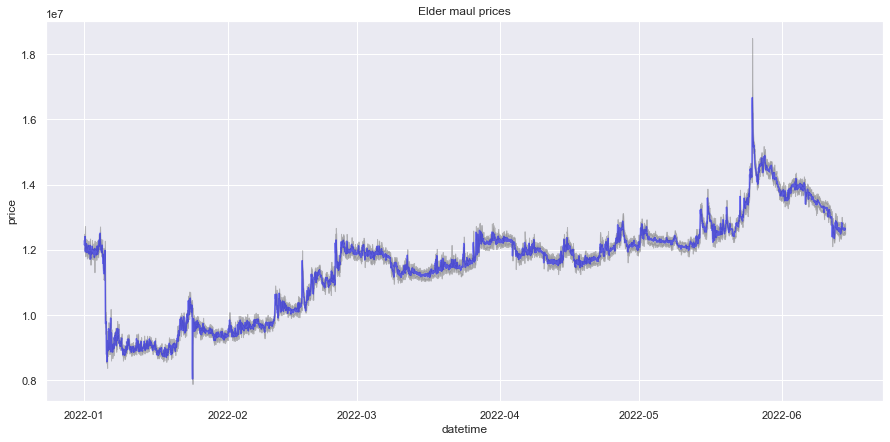

In [7]:
plot_single_item_prices(21003)

### Detect and remove outliers

A number of items seem to have a few outliers in the prices data.

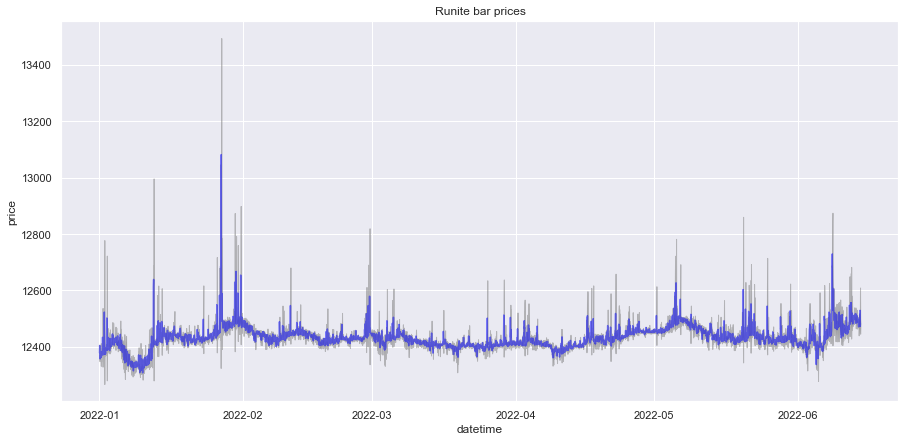

In [8]:
plot_single_item_prices(2363)

In [9]:
df = prices[prices['item_id'] == 2363].copy()
df['price_change'] = df.sort_values('datetime')['price'].diff()
df.loc[df['price_change'].isna(), 'price_change'] = 0

<AxesSubplot:xlabel='price_change', ylabel='Count'>

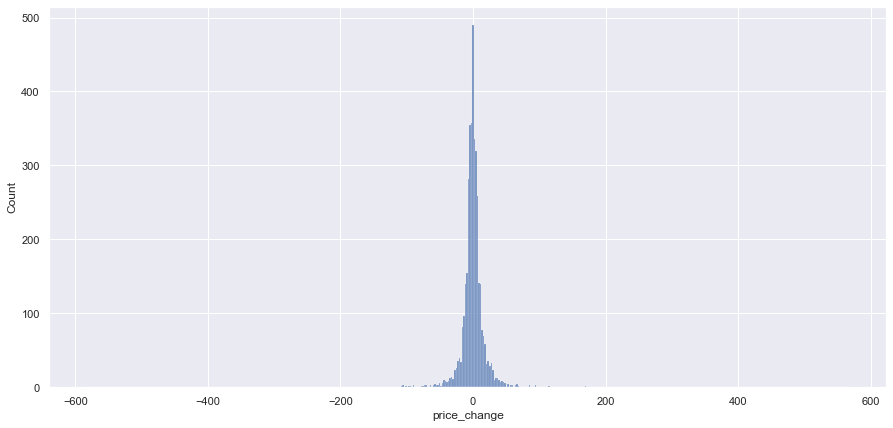

In [10]:
sns.histplot(df['price_change'], bins=500)

Difference is normally distributed - use z scores to remove outliers

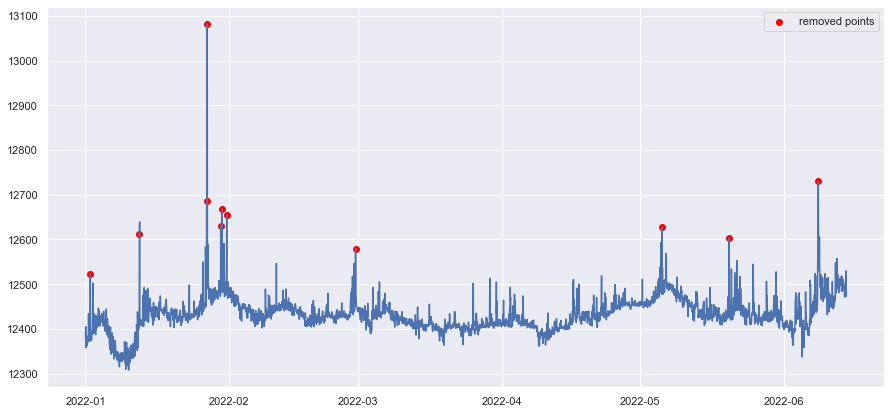

In [11]:
df['zscore'] = zscore(df['price_change'])
anomalies = df[df['zscore'] > 5][['item_id', 'datetime']]
anomalies['anomalous'] = 1

df = pd.merge(df, anomalies, on=['item_id', 'datetime'], how='left')
df.loc[df['anomalous'].isna(), 'anomalous'] = 0

plt.plot(df['datetime'], df['price'])
plt.scatter(df.loc[df['anomalous'] == 1, 'datetime'], df.loc[df['anomalous'] == 1, 'price'], color='red', label='removed points')
plt.legend()
plt.show()

In [12]:
prices = remove_price_outliers(prices)

### Impute missing periods

In [13]:
prices = fill_missing_data(prices)

### DTW find similar clusters of items

In [14]:
prices = load_preprocessed_data(n_hours=6)

Local DB found, checking for updated data...
Progress 0/9
Progress 1/9
Progress 2/9
Progress 3/9
Progress 4/9
Progress 5/9
Progress 6/9
Progress 7/9
Progress 8/9
Latest price data loaded, 9 new timesteps saved


In [16]:
# prices['price_scaled'] = prices.groupby('item_id')['price'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
prices['price_scaled'] = prices.groupby('item_id')['price'].transform(lambda x: (x - x.mean()) / x.std())

<AxesSubplot:xlabel='datetime', ylabel='price_scaled'>

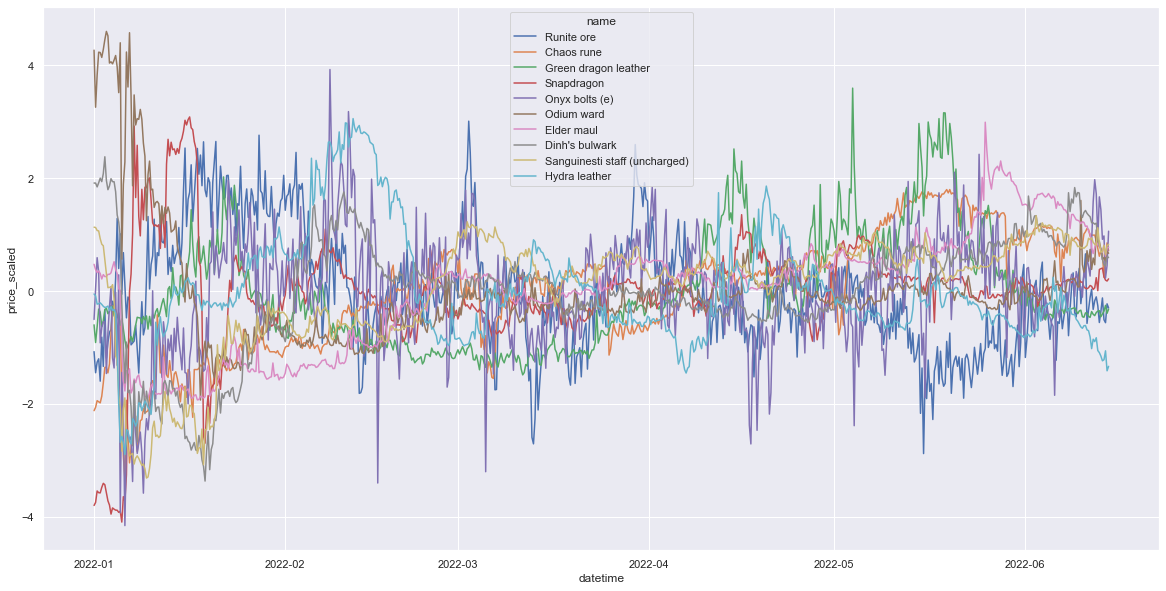

In [17]:
prices_sample = prices[prices['item_id'].isin(prices['item_id'].sample(10))]
sns.set(rc={'figure.figsize':(20, 10)})
sns.lineplot(data=prices_sample, x='datetime', y='price_scaled', hue='name')

In [18]:
from tslearn.clustering import TimeSeriesKMeans

# Reshape timeseries for dtw clustering
prices_wide = prices.pivot(index='datetime', columns='name', values='price_scaled')

C:\Users\joshu\Documents\Dev\osrs-ge-prices\venv\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [53]:
%%time

dba_km = TimeSeriesKMeans(n_clusters=5,
                          metric="dtw",
                          random_state=42,
                          max_iter=5,
                          max_iter_barycenter=5,
                          n_jobs=-1)
y_pred = dba_km.fit_predict(np.array(prices_wide).T)
# labels = dict(zip(df_covid_pivot.index, y_pred))

CPU times: total: 5min 16s
Wall time: 2min 36s


In [54]:
cluster_key = pd.DataFrame({
    'name': prices_wide.columns,
    'cluster': y_pred
})

In [55]:
cluster_key['cluster'].value_counts()

1    68
4    67
0    57
3    31
2    19
Name: cluster, dtype: int64

In [61]:
# Show some from each cluster
cluster_sample = cluster_key.groupby('cluster').sample(7)
cluster_sample = pd.merge(prices, cluster_sample, on='name', how='inner')

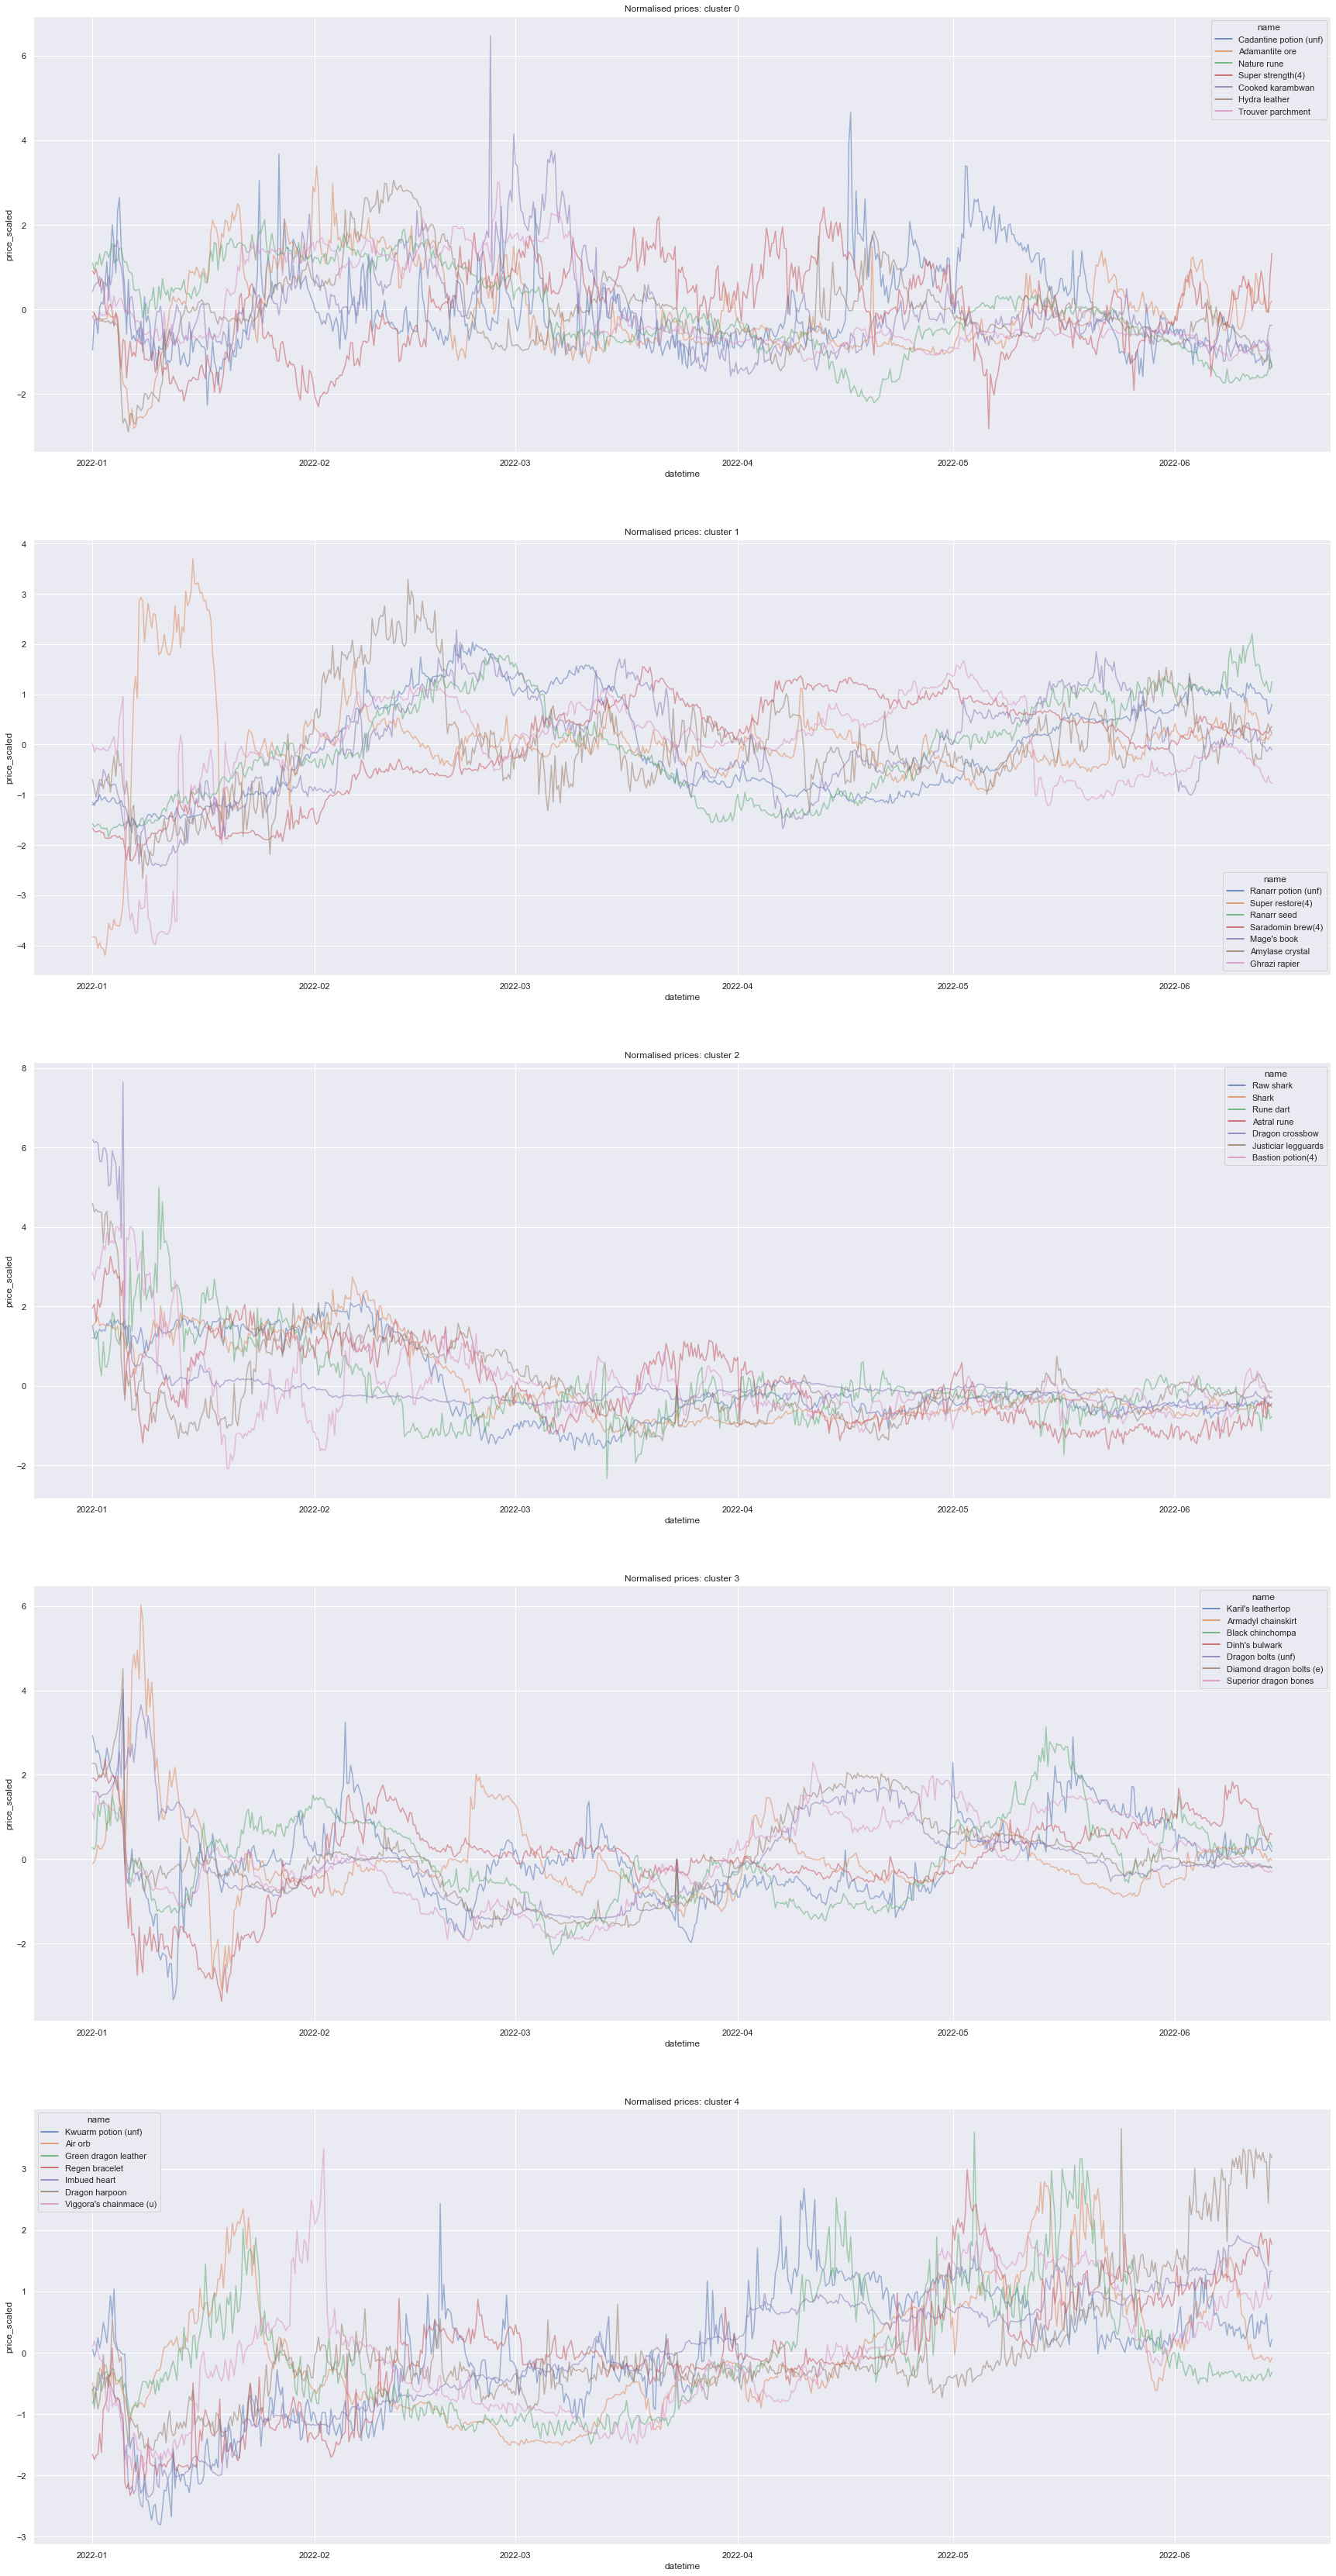

In [62]:
clusters = cluster_sample['cluster'].sort_values().unique()

fig, ax = plt.subplots(len(clusters), 1, figsize=(30, 60))

for i, cluster in enumerate(clusters):
    sns.lineplot(
        data=cluster_sample.query(f'cluster == {cluster}'),
        x='datetime',
        y='price_scaled',
        hue='name',
        alpha=0.5,
        ax=ax[i]
    )
    ax[i].title.set_text(f'Normalised prices: cluster {cluster}')

plt.show()